# Lab session of Image Analysis
## BE 5. Deep Learning Applications to Image Processing
### Duration: 2h


**Instructions:** 
- Submit a single **notebook** for each group (up to two people per group) of the session.
- Name it **beX_name1_name2**, with **X** denoting the number of the lab session and **name1,2** your surnames.
- The notebook acts as a report for your work and has to contain both the **code**, your **outputs** (images, plots, etc.), and the **answers** to the theory question.
- Upload the notebook in the **Travaux** section on **Chamilo**, within the folder corresponding to the supervisor associated to this session. If you were already assigned a personal repository for your group, you can also upload this material through **git**.

**Deadline submission:** 
- The material should be submitted within a week from the lab work.

**Lab setup:**
- For this session you are required to work on **Google Colab**
- Go to `https://colab.research.google.com/` and login to your Google account
- Click on `File -> Upload` notebook and choose the `be5.ipynb` file
- Click on the folder icon on the left bar and wait for the left tab to charge
- Click on the upload button (the icon is a paper with an up-arrow) and transfer the files `material.zip` and `requirements.txt`
- Your notebook is saved automatically to your Google Drive account
- To save your work locally for submission, click on `File -> Download -> .ipynb`
- If you notice weird error messages, try `Runtime -> Restart session and run all`

**Notes:**
- We allow either the `ipynb` or `pdf` file format (on Jupyterhub `File -> Download as -> pdf via LaTeX (.pdf)`).
- Please do not change the content of the cells other than those marked with `# To do` or `Answers: [To do]`.
- If you need an extra cell for your answers, add a new one by clicking on the left-side outline of your current cell and press `B`.
- If you need to type plain text, select `Markdown` from the dropdown menu above to change the cell type. 


**Objectives of this lab work:** 
- Getting started with deep learning
- Applying deep learning for object detection
- Designing and applying deep learning for image denoising

In [1]:
from pathlib import Path
import zipfile

# Extract zip file with the material for this session
material_file = "material.zip"
if Path(material_file).exists():
    with zipfile.ZipFile(material_file, 'r') as zip_ref:
        zip_ref.extractall()

%pip install -r requirements.txt
%matplotlib inline

In [2]:
from __future__ import annotations # Compatibility with Python 3.8
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
import torchinfo
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

data_folder = "datasets/"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Helper functions

For this session, we provide a set of helper functions in order to avoid boilerplate code. The functions are explained in more detail when relevant in the next section, but as a quick reminder:
- `train_model`
    - Code to train the model. Some parameters that will be not explained in the following are:
    - `evaluate_accuracy`: Set to `True` only for image classification problems.
    - `save_subfolder`: If not `None`, it saves your trained model to a given folder under `models`. 
        - **IMPORTANT**: Provide a different `save_subfolder` name every time you train a different model.
    - `force_train`: Set to `True` to train the model again from scratch (if not, it loads from the data in `save_folder`).
- `test_model`: Code to test the model
    - `evaluate_accuracy`: Set to `True` only for image classification problems.
- `visualize_image_labels`: Code to visualize images for classification problems.
- `visualize_image_regression`: Code to visualize images for regression problems.
- `visualize_loss`: Plots the losses for each epoch.
    - `accuracy`: Set to `None` for any problem that is not image classification. 

In [3]:
def visualize_image_labels(
    data_loader: DataLoader,
    classes: list[str] | None = None,
    image_matrix: tuple[int, int] = (2, 4),
    save_path: Path | str | None = None,
    model: nn.Module | None = None,
) -> None:
    """Visualize images and associated labels."""
    num_images = image_matrix[0] * image_matrix[1]
    fig, ax = plt.subplots(*image_matrix)
    fig.set_size_inches(18.5, 10.5, forward=True)
    current_image = 0
    for data in data_loader:
        image, target = data
        if model is not None:
            is_training = model.training
            with torch.no_grad():
                model.eval()
                prediction = model(image.to(device))
            if is_training:
                model.train()
        else:
            prediction = target
        for jj in range(image.shape[0]):
            idx_x, idx_y = np.unravel_index(jj, image_matrix)
            image_numpy = image[jj, :, :, :].cpu().numpy().transpose((1, 2, 0))
            image_numpy = np.clip(image_numpy, 0, 1)
            options = {"cmap": "gray"} if image_numpy.shape[2] == 1 else {}
            ax[idx_x, idx_y].imshow(image_numpy, **options)
            if classes is not None:
                prediction_idx = prediction[jj, :].argmax()
                target_idx = target[jj, :].argmax()
                title_label = "Class" if model is None else "Predicted"
                title_color = "green" if prediction_idx == target_idx else "red"
                accuracy_label = f"\nConfidence: {prediction[jj, prediction_idx] * 100:.1f}%"
                accuracy_label = accuracy_label + f"\nReal class: {classes[target_idx]}"
                accuracy_label = accuracy_label if model is not None else ""
                title = f"{title_label}: {classes[prediction_idx]}{accuracy_label}"
                ax[idx_x, idx_y].set_title(title, color=title_color, fontsize=16)
            current_image = current_image + 1
            if current_image >= num_images:
                fig.tight_layout()
                plt.show() if save_path is None else fig.savefig(f"{save_path}")
                return
    fig.tight_layout()
    plt.show() if save_path is None else fig.savefig(f"{save_path}")
            

def visualize_image_regression(
    data_loader: DataLoader,
    model: nn.Module | None = None,
    num_images: tuple[int, int] = 5,
    save_path: Path | str | None = None,
) -> None:
    """Visualize images for regression."""
    idx_max = 2 if model is None else 3
    fig, ax = plt.subplots(idx_max, num_images, squeeze=False)
    fig.set_size_inches(18.5, 10.5, forward=True)
    labels = ["Input image", "Target image", "Reconstructed image"]

    current_image = 0
    for data in data_loader:
        image, target = data
        prediction = target
        if model is not None:
            is_training = model.training
            with torch.no_grad():
                model.eval()
                prediction = model(image.to(device))
            if is_training:
                model.train()
        view_list = [image, target, prediction]
        for jj in range(image.shape[0]):
            for ii in range(idx_max):
                view = view_list[ii]
                view_numpy = view[jj, :, :, :].cpu().numpy().transpose((1, 2, 0))
                options = {"cmap": "gray"} if view_numpy.shape[2] == 1 else {}
                ax[ii, current_image].imshow(view_numpy, **options)
                ax[ii, current_image].set_title(f"{labels[ii]}", fontsize=16)
            current_image = current_image + 1
            if current_image >= num_images:
                fig.tight_layout()
                plt.show() if save_path is None else fig.savefig(f"{save_path}")
                return
    fig.tight_layout()
    plt.show() if save_path is None else fig.savefig(f"{save_path}")


def visualize_loss(
    cost: np.ndarray,
    acc: np.ndarray | None = None,
    save_path: Path | str | None = None
) -> None:
    """Visualizes cost and accuracy evolution with epochs."""
    with plt.style.context("ggplot"):
        num_epochs = cost.shape[0]
        labels = ["Loss", "Accuracy"]
        value = [cost, acc]
        idx_max = 1 if acc is None else 2
        fig, ax = plt.subplots(1, idx_max, squeeze=False)
        fig.set_size_inches(18.5, 10.5, forward=True)
        for ii in range(idx_max):
            ax[0, ii].plot(np.arange(1, num_epochs+1), value[ii])
            ax[0, ii].set_xlabel("Epochs", fontsize=16)
            ax[0, ii].set_title(f"{labels[ii]}", fontsize=16)
        fig.tight_layout()
        plt.show() if save_path is None else fig.savefig(f"{save_path}")


def save_model(function):
    """Wrapper function to save/load the model dynamically."""
    def func_wrapper(
        *args,
        save_subfolder: str | None = None,
        force_train: bool = False,
        **kwargs,
    ):
        protected_folders = [
            "cifar_10_linear",
            "fashion_mnist_linear",
            "mnist_autoencoder_linear",
            "mnist_autoencoder_convolutional",
            "mnist_denoiser",
        ]
        model = kwargs["model"]
        device = kwargs["device"]
        model_folder = "models/"

        model_folder = Path(model_folder)
        if not model_folder.exists():
            raise IOError("Please copy the 'model' folder to your workspace.")
        if save_subfolder is None:
            return function(*args, **kwargs)
        save_folder = model_folder / save_subfolder
        save_file_model = save_folder / "model.pth"
        save_file_cost = save_folder / "cost.npy"
        save_file_acc = save_folder / "acc.npy"
        if not force_train and save_file_model.exists():
            cost = np.load(f"{save_file_cost}")
            acc = np.load(f"{save_file_acc}")
            model.load_state_dict(torch.load(f"{save_file_model}"))
            model.to(device)
            return model, cost, acc
        
        reserved = [Path(model_folder) / res for res in protected_folders]
        if save_folder in reserved:
            raise ValueError("Protected folder. Please choose another name for the 'save_subfolder' field.")
        model, cost, acc = function(*args, **kwargs)
        if not save_folder.exists():
            save_folder.mkdir()
        np.save(file=f"{save_file_cost}", arr=cost)
        np.save(file=f"{save_file_acc}", arr=acc)
        torch.save(obj=model.state_dict(), f=f"{save_file_model}")
        return model, cost, acc
    return func_wrapper


@save_model
def train_model(
    data_loader: DataLoader,
    epochs: int,
    optimizer,
    criterion,
    *,
    device: str,
    model: nn.Module,
    evaluate_accuracy: bool = False,
) -> tuple[nn.Module, np.ndarray, np.ndarray]:
    """Generic wrapper function to train models."""
    cost = torch.empty((epochs, len(data_loader)), device= device, dtype=torch.float32)
    acc = torch.empty((epochs, len(data_loader)), device=device, dtype=torch.float32)
    is_training = model.training
    model.train()
    for epoch in tqdm(range(epochs)):
        for batch, data in enumerate(data_loader):
            images, targets = data
            images = images.to(device)
            targets = targets.to(device)
            predictions = model(images)
            loss = criterion(predictions, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            cost[epoch, batch] = loss.item()
            if evaluate_accuracy:
                equality = predictions.argmax(1) == targets.argmax(1)
                acc[epoch, batch] = equality.type(torch.float32).mean().item()
    cost = cost.mean(dim=1).cpu().numpy()
    acc = acc.mean(dim=1).cpu().numpy()
    if not is_training:
        model.eval()
    return model, cost, acc


def test_model(
    data_loader: DataLoader,
    criterion,
    model: nn.Module,
    device: str,
    evaluate_accuracy: bool = False,
) -> tuple[np.ndarray, np.ndarray]:
    """Generic wrapper function to test models."""
    cost = torch.empty((len(data_loader)))
    acc = torch.empty((len(data_loader)))
    is_training = model.training
    model.eval()
    with torch.no_grad():
        for batch, data in enumerate(data_loader):
            images, targets = data
            images = images.to(device)
            targets = targets.to(device)
            predictions = model(images)
            loss = criterion(predictions, targets)

            cost[batch] = loss.item()
            if evaluate_accuracy:
                equality = (predictions.argmax(1) == targets.argmax(1))
                acc[batch] = equality.type(torch.float).mean().item()
    if is_training:
        model.train()
    return cost.mean().cpu().numpy(), acc.mean().cpu().numpy()

## Getting started

Two open source alternatives are the most commonly used to setup a deep learning based project for image processing:
- The `Keras` machine learning API of `TensorFlow`, developed by the `Google Brain` team at `Google`
- The `PyTorch` machine learning framework based on `Torch`, originally developed by the `Meta AI` at `Meta`

While they historically involved different workflows, they eventually evolved to being structurarly similar for the main operations; the operations include:

- **Collecting a dataset**: In supervised learning, we collect couples of inputs and reference results (_targets_);
- **Preprocessing the dataset**: we prepare the dataset and the associated metadata to be compatible to the network format;
- **Defining the architecture of the network**: We define all the layers that compose the architecture for deep learning;
- **Defining the cost function**: We define the metric to compare the predicted results and the target (reference) values;
- **Training the model**: The coefficients of the network are updated (typically, via _back propagation_) for multiple iterations (_epochs_) in order to minimize the cost function;
- **Testing the model**: The resulting model is tested on a separate dataset to assess its performances.

We will describe these operations in detail for image classification and image regression.

## Image classification
The target of image classification is categorize images with the highest accuracy. In the following example, the target is to train a model to recognize features from an image and assign a class from a set of possible options.

### Loading the dataset
In the following example, we load the `Fashion MNIST` a classical dataset of $28 \times 28$ grayscale images of clothing items (60,000 for training and 10,000 for testing). Each image is tagged by one associated index, which identifies its class from a set of 10 available labels.

By taking an element of dataset, a tuple is returned containing:
- An image opened with the `PIL` library (a Python library for basic operations with images)
- The associated index from the given list of classes

**Note**: Some datasets can be slow to download. If there is any issue, please ask your supervisor to provide the datasets from a flash drive/hard disk.

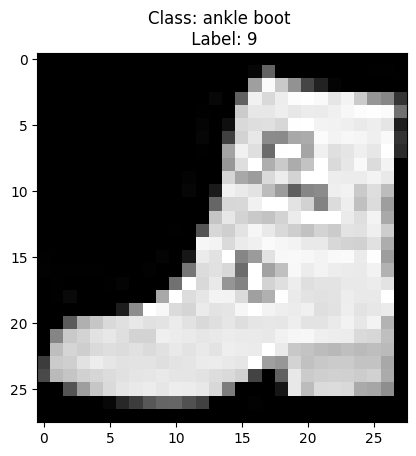

In [4]:
classes = ["T-shirt", "trouser", "pullover", "dress", "coat", "sandal", "shirt", "sneaker", "bag", "ankle boot"]

dataset_test = torchvision.datasets.FashionMNIST(
    root=data_folder, train=False, download=True,
)

idx_element = 7550
image, label = dataset_test[idx_element]

fig, ax = plt.subplots()
ax.imshow(image, cmap="gray")
ax.set_title(f"Class: {classes[label]} \n Label: {label}")
plt.show()

### Preprocessing the dataset
While the dataset may have specified a specific way to load the image from the database, it is often necessary to adapt them to the specific deep learning architecture. Those transformations can be applied to both the image and the labels.

- **Images**: 
    - For `torch` to properly process images, it is necessary to convert them to a `torch.Tensor` format.
    - This format is a specific datatype for multidimensional arrays similar to `numpy` arrays, with some added functionalities for the operations with `PyTorch`.
    - Among the main differences, the tensor format specifies the dimension of the images in row-major order, that we remind here along with some common libraries (below, `batches` defines the group of images that will be processed together):
        - **Column-major order (PIL, matplotlib, OpenCV, scikit-image, Keras)**: `(rows, columns, channels, batches)`
        - **Row-major order (PyTorch)**: `(batches, channels, rows, columns)`

- **Labels**:
    - To tag one image, there are various possible choices, of which the most common ones are:
        - **Label encoding**: A specific class is assigned a certain index (e.g. `ankle boot` is `9`)
        - **One-hot encoding**: The classes are assigned a binary array (e.g. `ankle boot` is `[0, ... , 0, 1, 0]`)
    - In the context of deep learning it is often common to encode classes with the so called `one-hot` encoding:
    - The one-hot encoding is useful for classification problems as it can be interpreted as the probability that a certain item belongs to a given class

In the following script we convert images to their tensor representation and labels to their one-hot representation, using the `torchvision.transforms` functionalities.


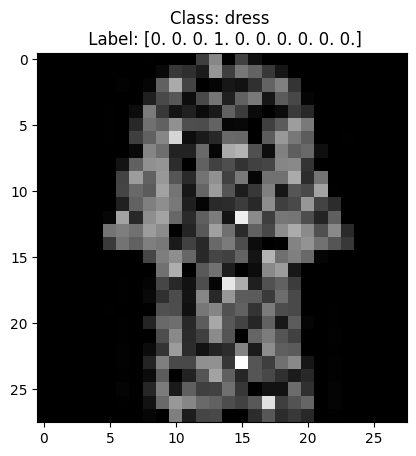

In [5]:
transform = transforms.ToTensor()
target_transform = transforms.Lambda(
    lambda x: torch.zeros((len(classes),), device=device, dtype=torch.float32)
                   .scatter_(0, torch.tensor(x, device=device), value=1)
)
dataset_train = torchvision.datasets.FashionMNIST(
    root=data_folder,
    train=True, 
    download=True, 
    transform=transform, 
    target_transform=target_transform,
)
dataset_test = torchvision.datasets.FashionMNIST(
    root=data_folder,
    train=False,
    download=True,
    transform=transform,
    target_transform=target_transform
)

idx_element = 570
image, label = dataset_test[idx_element]
fig, ax = plt.subplots()
ax.imshow(image.cpu().numpy().transpose((1, 2, 0)), cmap="gray")
ax.set_title(f"Class: {classes[label.argmax()]} \n Label: {label.cpu().numpy()}")
plt.show()

### Creating a dataloader
For deep learning, it is often useful to process the images in chunks, each of which is known as a **batch**:
- The `torch` library provides the `torch.utils.data.Dataloader` function to streamline this process.
- By setting `shuffle=True`, the images loaded at each batch are randomized until all the elements dataset are used.
- We provide a custom function `visualize_image_labels` to plot some samples from this batch

At this stage we also separate the dataset into two categories:
- **Training dataset**: used to make the model learn how the input maps to the outputs.
- **Testing dataset**: used to assess the performances of the network.

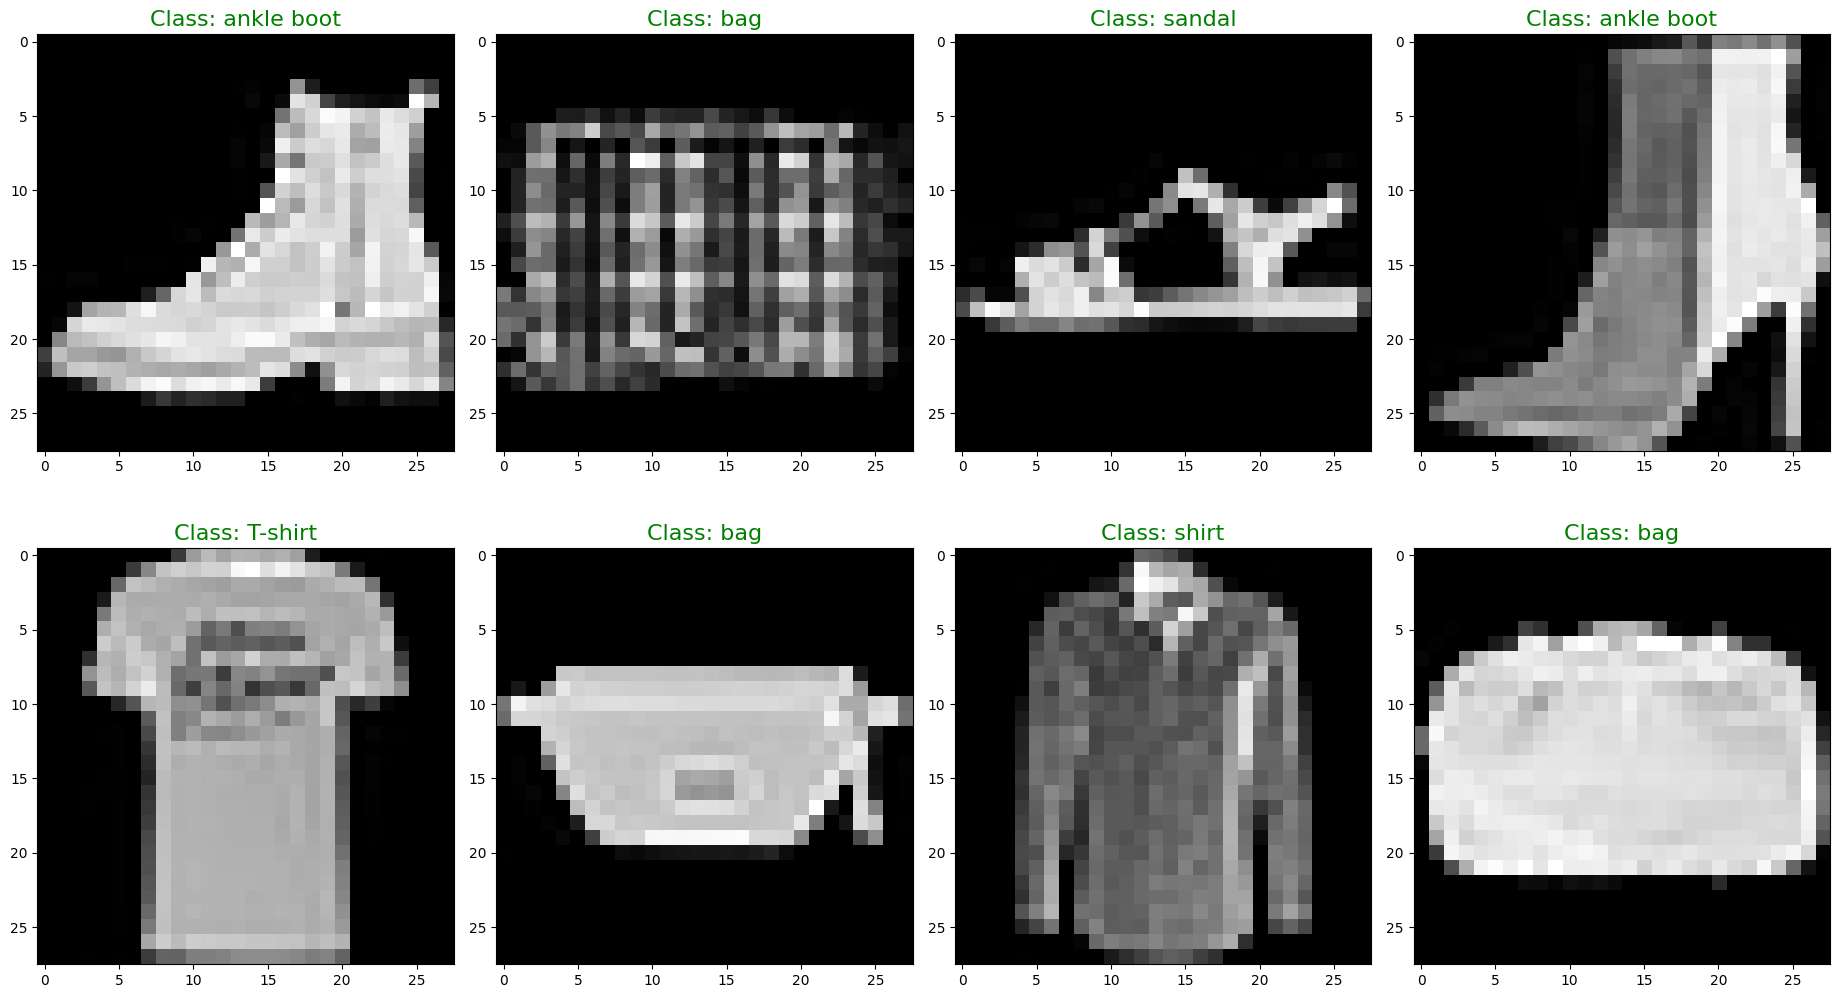

In [6]:
batch_size = 32
data_loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

visualize_image_labels(data_loader=data_loader_test, classes=classes, model=None)

### Defining the architecture of the network
- In `torch` a network is defined through a class, which inherits from the `torch.nn.Module` class.
- The class requires two methods:
    - In the `__init__` method, we define all the parameters saved by the architecture (e.g., `self.layers` in the example below). Those parameters will be updated during the training phase of the system.
    - In the `forward` method, we define how the model processes a certain input to get their prediction (e.g., in the case of classification, that would be a prediction of the label of the image).
- Once the class is instantiated in the `model` variable, there are various options to visualize its structure:
    - With `print(model)`
    - With external visualization tools such as `tensorboard` ([https://pytorch.org/docs/stable/tensorboard.html])
    - With the `torchinfo.summary` function from the `torchinfo` library (not associated with `Pytorch`), which requires to specify the size of the input
- In this session we will use this last solution, as it provides the most information in a very compact wrapper

### Classifier architecture
In the following example, we show the most basic example for a classifier network, where a series of operations are cascaded together with the `nn.Sequential` function.
In this architecture, after the image is reshaped to a vector with `nn.Flatten`, we have:
- A **fully connected layer**, defined by `nn.Linear` which transforms the $28 \times 28$ input pixels into 10 classes
- A **SoftMax** function, defined by `nn.Softmax`, which imposes a sum-to-1 constraint to the result, in order to represent the probability associated to each class

In [7]:
class LinearNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 10),
            nn.Softmax(dim=1),
        )

    def forward(self, x):
        return self.layers(x)
    

model = LinearNetwork()
print(torchinfo.summary(model=model, input_size=(batch_size, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
LinearNetwork                            [32, 10]                  --
├─Sequential: 1-1                        [32, 10]                  --
│    └─Flatten: 2-1                      [32, 784]                 --
│    └─Linear: 2-2                       [32, 10]                  7,850
│    └─Softmax: 2-3                      [32, 10]                  --
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (M): 0.25
Input size (MB): 0.10
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.13


### Training the network
To train the network, the couples images/targets are fed to a backpropagation solver, which updates the weights of the systems.
We provide a `train_model` function to perform those operations in your place, which requires:
- `data_loader`: The training dataloader to feed the images and the expected outputs;
    - **IMPORTANT**: Never give the testing dataset to this function, otherwise the network updates with information it should not be aware of.
- `model`: the network model to be updated;
- `criterion`: the cost function to optimize, such as:
    - `nn.BCELoss()` for the **Binary Cross Entropy**;
    - `nn.MSELoss()` for the **Mean Square Error**.
- `epochs`: the amount of iterations of the training algorithm.
- `optimizer`: A package to implement the optimization algorithm:
    - The learning rate parameter `lr` of the optimizer is critical for the convergence speed:
    - High values of `lr`: Less required amount of `epochs`, higher risk of divergence/oscillations
    - Low values of `lr`: High required amount of `epochs`, low risk of divergence/oscillations

We provide a function `visualize_loss` to plot the behavior of the loss measured by the cost function while training. While it might have some spikes, its behavior should be generally decreasing if everything works correctly.


_Note_: by running `train_model`:
- we save automatically the model under `models` to the `save_subfolder` that you can specify.
- The model state is automatically loaded afterwards, to save time.
- Please set `force_train` to `True` in case you want to train the model again from scratch.

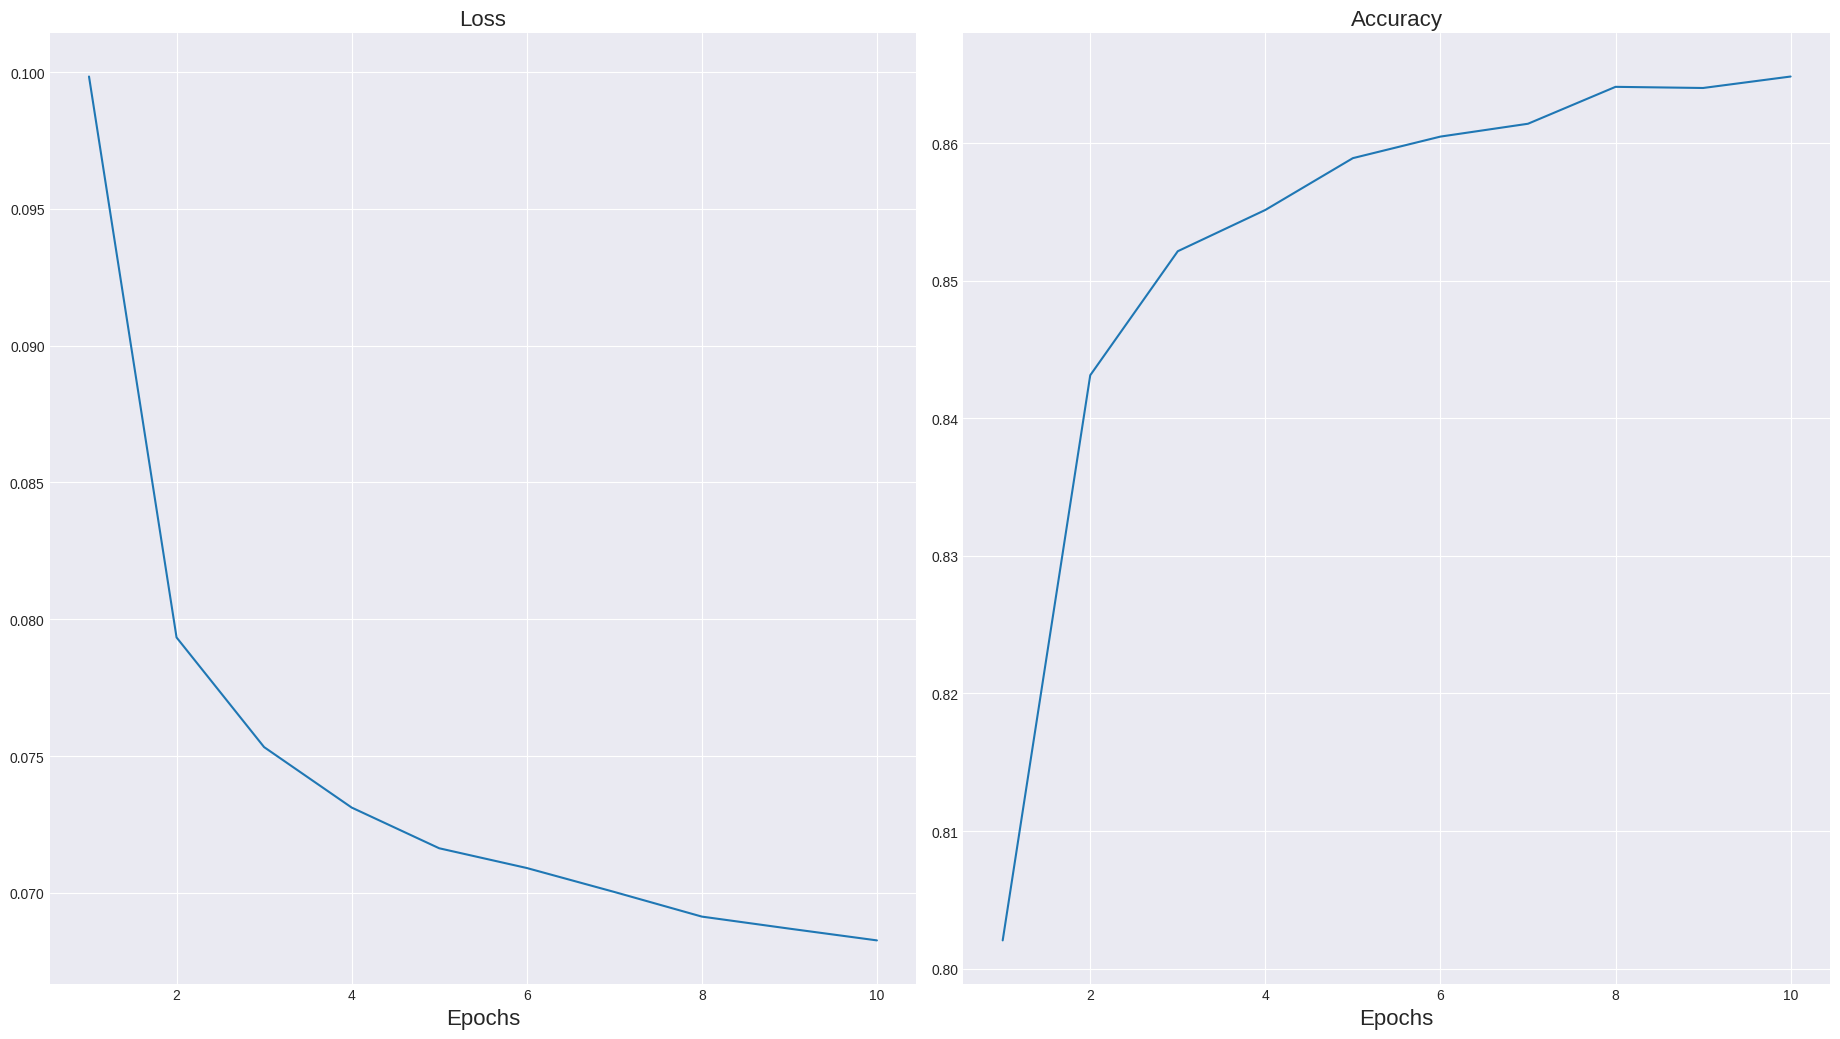

In [8]:
epochs = 10
learning_rate = 0.001

model = LinearNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)

model, cost_train, acc_train = train_model(
    data_loader=data_loader_train,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    device=device,
    evaluate_accuracy=True,
    save_subfolder="fashion_mnist_linear",
    force_train=False,
)

visualize_loss(cost=cost_train, acc=acc_train)

### Testing the model
We can finally evaluate our model, by feeding data from the testing dataset to the model we just trained.
- For classification problems, the typical goal is to maximize the accuracy of the prediction.
- We provide a function `test_model` to simplify this operation.

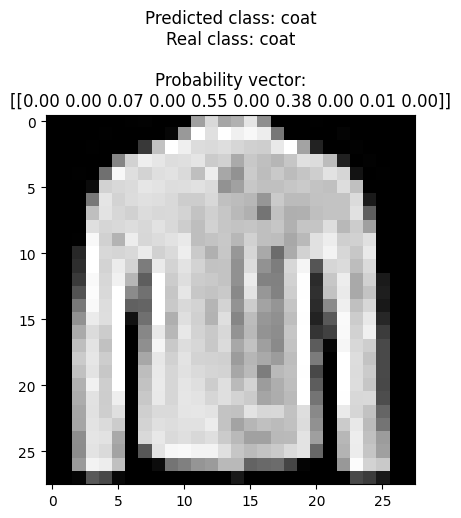

Test accuracy: 84.4%
Test loss:     0.0771


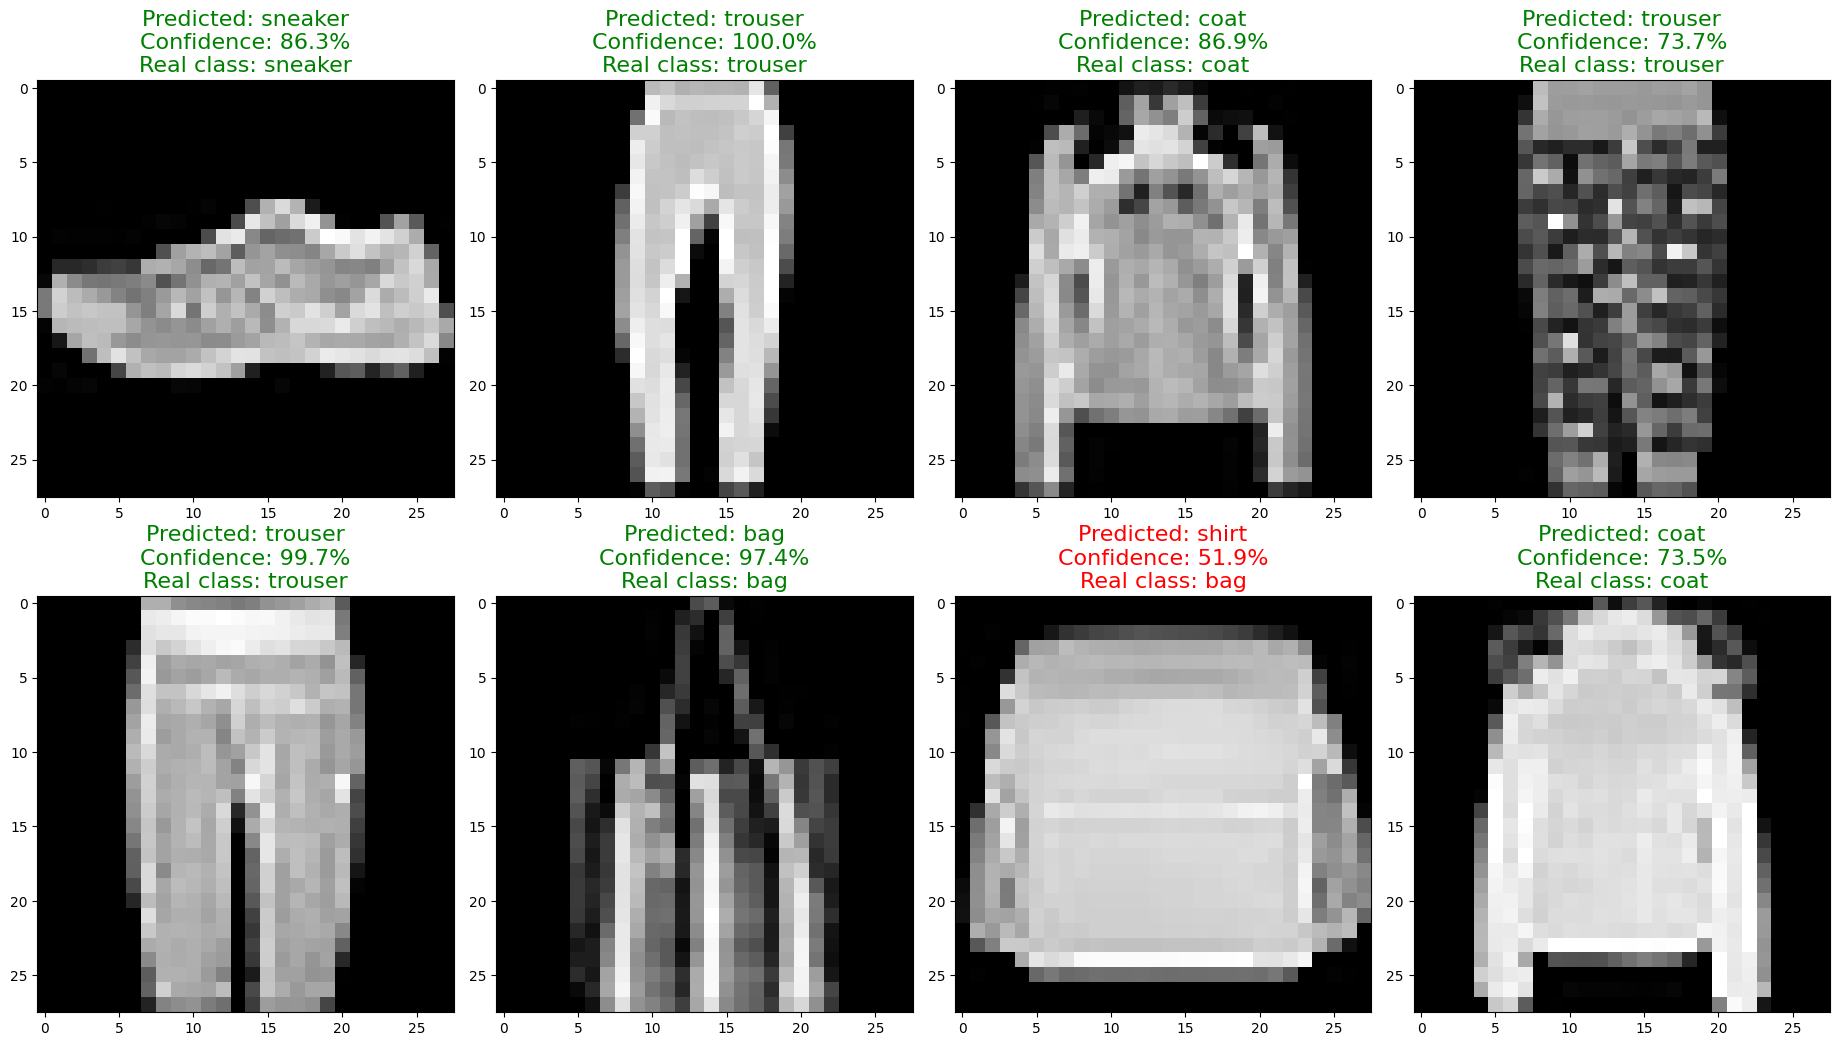

In [9]:
idx_element = 50
image, label = dataset_test[idx_element]
image = image.to(device)
predicted = model(image)

_, ax = plt.subplots()
ax.imshow(image.cpu().numpy().transpose((1, 2, 0)), cmap="gray")
prediction_show = np.array2string(predicted.detach().cpu().numpy(), formatter={'float_kind':lambda x: "%.2f" % x})
ax.set_title(
    f"Predicted class: {classes[predicted.argmax()]}\n" +
    f"Real class: {classes[label.argmax()]}\n\n" +
    f"Probability vector:\n{prediction_show}"
)
plt.show()


cost_test, acc_test = test_model(
    data_loader=data_loader_test,
    model=model, 
    criterion=criterion, 
    device=device, 
    evaluate_accuracy=True,
)
print(f"Test accuracy: {acc_test * 100:.1f}%")
print(f"Test loss:     {cost_test:.4f}")
visualize_image_labels(data_loader=data_loader_test, classes=classes, model=model)


### _Laboratory activity_

**Exercise**:
- We want to test some different configurations for our network, in particular:
    - Set up a new network `NonLinearNetwork` adding a hidden layer with 512 nodes
    - The layers should be fully connected, and the hidden nodes should use a ReLU activator (`nn.ReLU()`).
    - Save the trained network to `save_subfolder="fashion_mnist_nonlinear"`
    - Train and test the new network on the Fashion MNIST dataset.
- _Hint_: You can copy/paste the code of the three previous cells to the one below for a headstart, and change the `LinearNetwork` class to the demanded one. 
- _Warning_: Training can take a few minutes depending on your device.

**Questions**:
- Why do we need an activation function between 2 fully connected layers in cascade?
- What are the advantages and disadvantages of increasing the amount of nodes in the hidden layer?


In [ ]:
# To do

### _Answers_:
[To do]

## Autoencoders
An autoencoder is specific network, whose target is to learn a compressed representation of the input data that can be reconstructed with minimal distortion.


### Loading the dataset
For this experiment, we employ the classic MNIST dataset, a database of 60,000 training and 10,000 monochromatic images of sizes $28 \times 28$, representing handwritten digits.

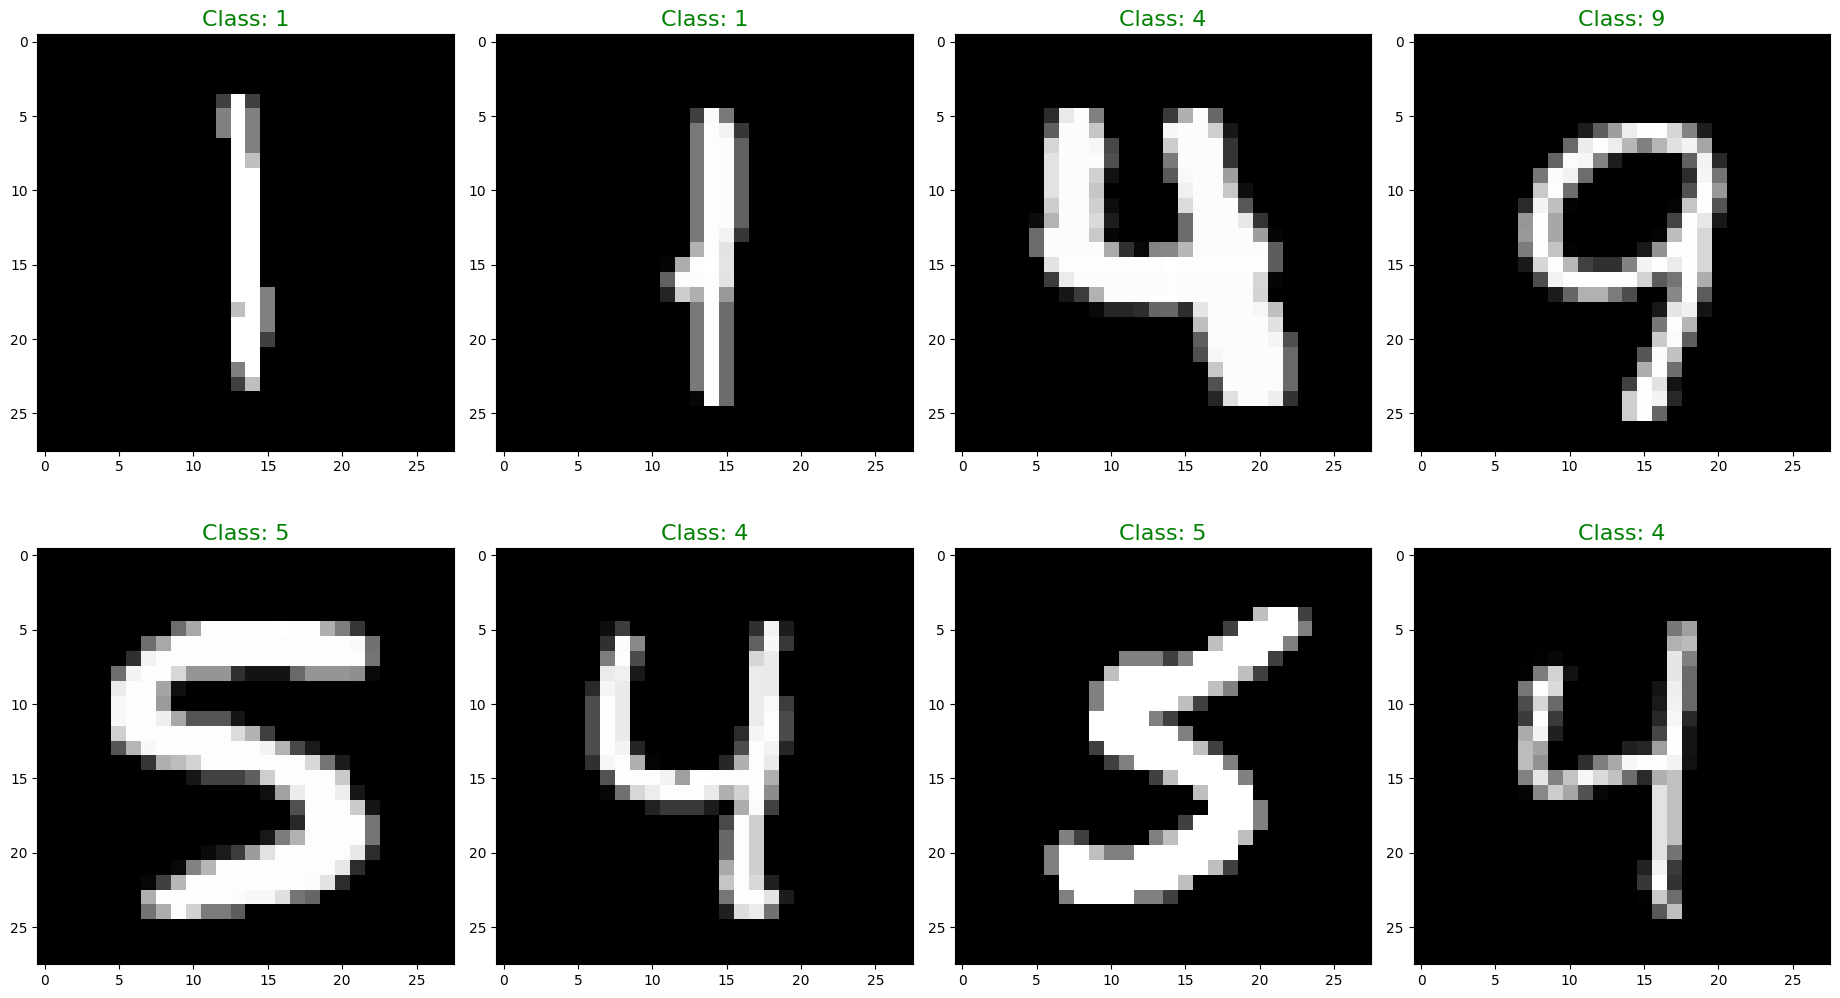

In [11]:
batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(device)),
])
target_transform = transforms.Lambda(
lambda x: torch.zeros((len(classes),), device=device, dtype=torch.float32)
                .scatter_(0, torch.tensor(x, device=device), value=1)
)
dataset_test = torchvision.datasets.MNIST(
    root=data_folder,
    transform=transform,
    target_transform=target_transform,
    train=False,
    download=True,
)
classes = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
data_loader = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True)
visualize_image_labels(
    data_loader=data_loader,
    classes=classes,
    model=None,
)

### Preprocessing the dataset

- For a regression problem we do not need to keep track of the label of the class, as the target is a reference image,
- To this end, we can modify use the `torch.data.utils.Dataset` to create a custom one in such a way that the target is our custom choice.
- In the case of autoencoders in particular, the input and the target image are the same. 

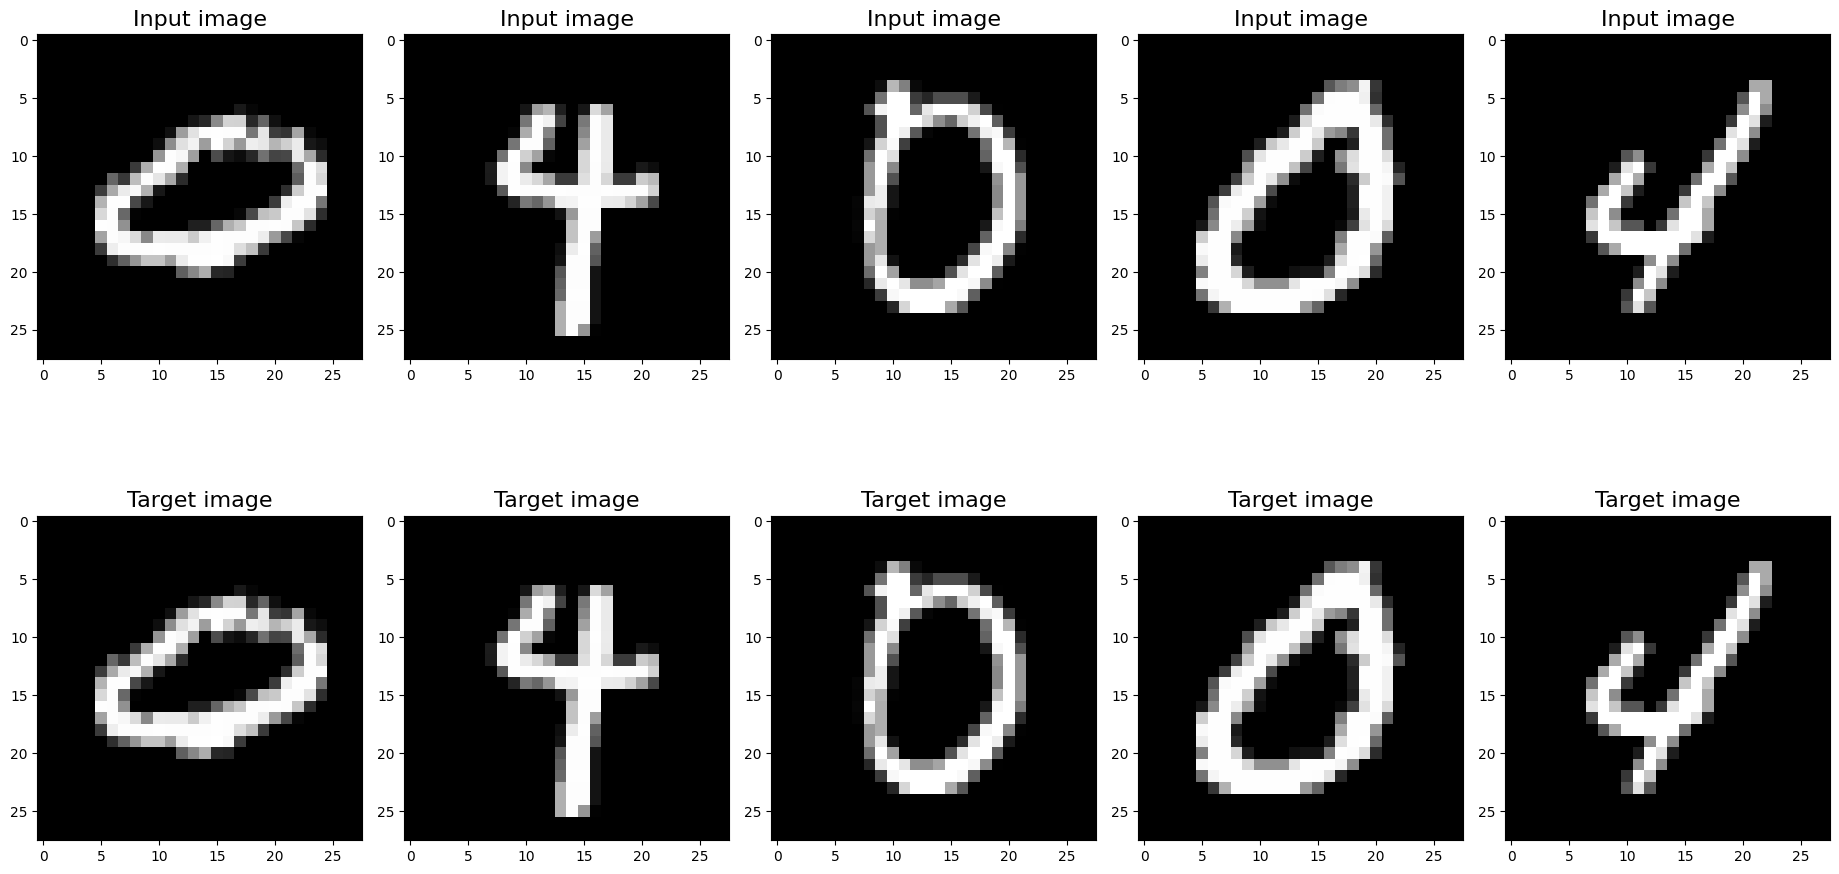

In [12]:
class MnistCustomDataset(Dataset):
    def __init__(
        self, 
        root: str, 
        train: bool = True,
        transform = None,
        target_transform = None,
    ):
        self.dataset = torchvision.datasets.MNIST(root=root, download=True, train=train)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]
        image, target = image, image
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return image, target

batch_size = 128
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.to(device)),
])
dataset_train = MnistCustomDataset(root=data_folder, train=True, transform=transform, target_transform=transform)
dataset_test = MnistCustomDataset(root=data_folder, train=False, transform=transform, target_transform=transform)

data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True)
visualize_image_regression(
    data_loader=data_loader_test,
    model=None,
    num_images=5,
)

### Training and testing the network
For the creation of the network, we can opt for the same strategy we employed before, using fully connected layers both to decode and to decode the image. 
In this setup, the amount of hidden nodes (`hidden_nodes`) defines the coefficients that are used as compression of the input image.

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoderLinear                        [128, 1, 28, 28]          --
├─Sequential: 1-1                        [128, 80]                 --
│    └─Flatten: 2-1                      [128, 784]                --
│    └─Linear: 2-2                       [128, 80]                 62,800
├─Sequential: 1-2                        [128, 1, 28, 28]          --
│    └─Linear: 2-3                       [128, 784]                63,504
│    └─Unflatten: 2-4                    [128, 1, 28, 28]          --
Total params: 126,304
Trainable params: 126,304
Non-trainable params: 0
Total mult-adds (M): 16.17
Input size (MB): 0.40
Forward/backward pass size (MB): 0.88
Params size (MB): 0.51
Estimated Total Size (MB): 1.79


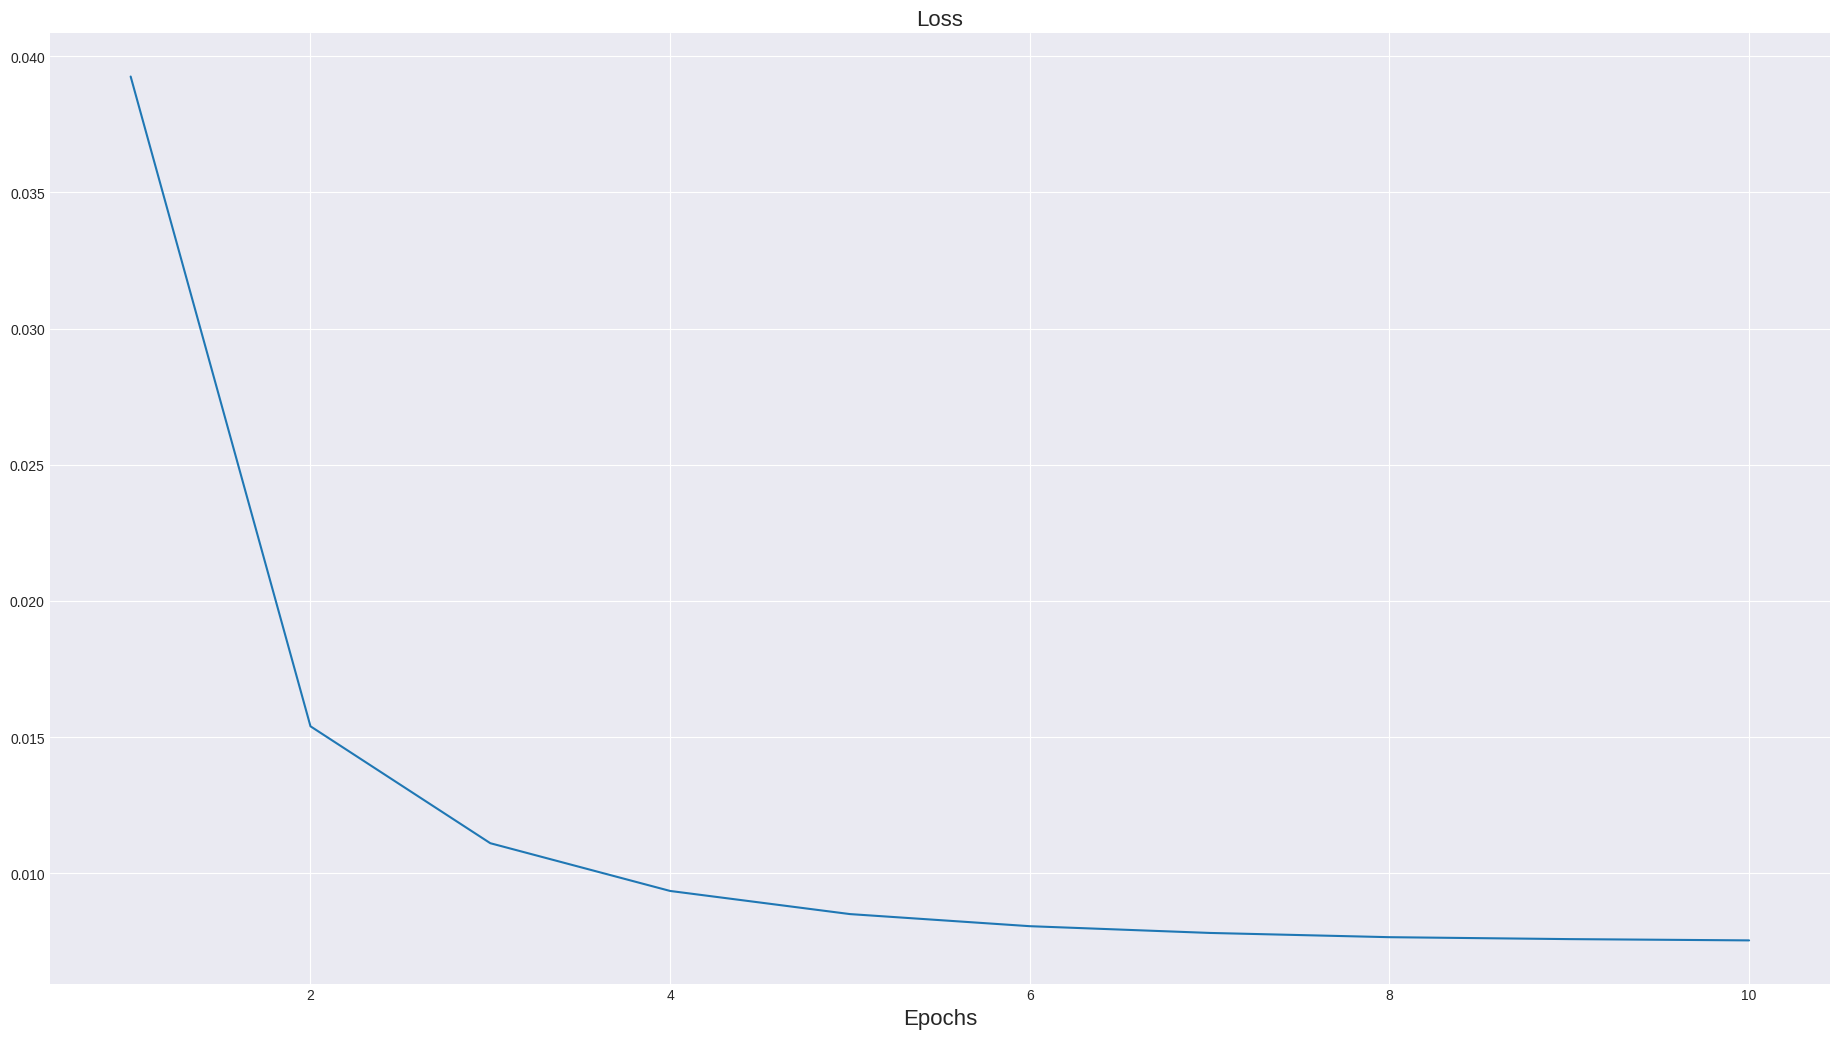

Cost: 0.0073


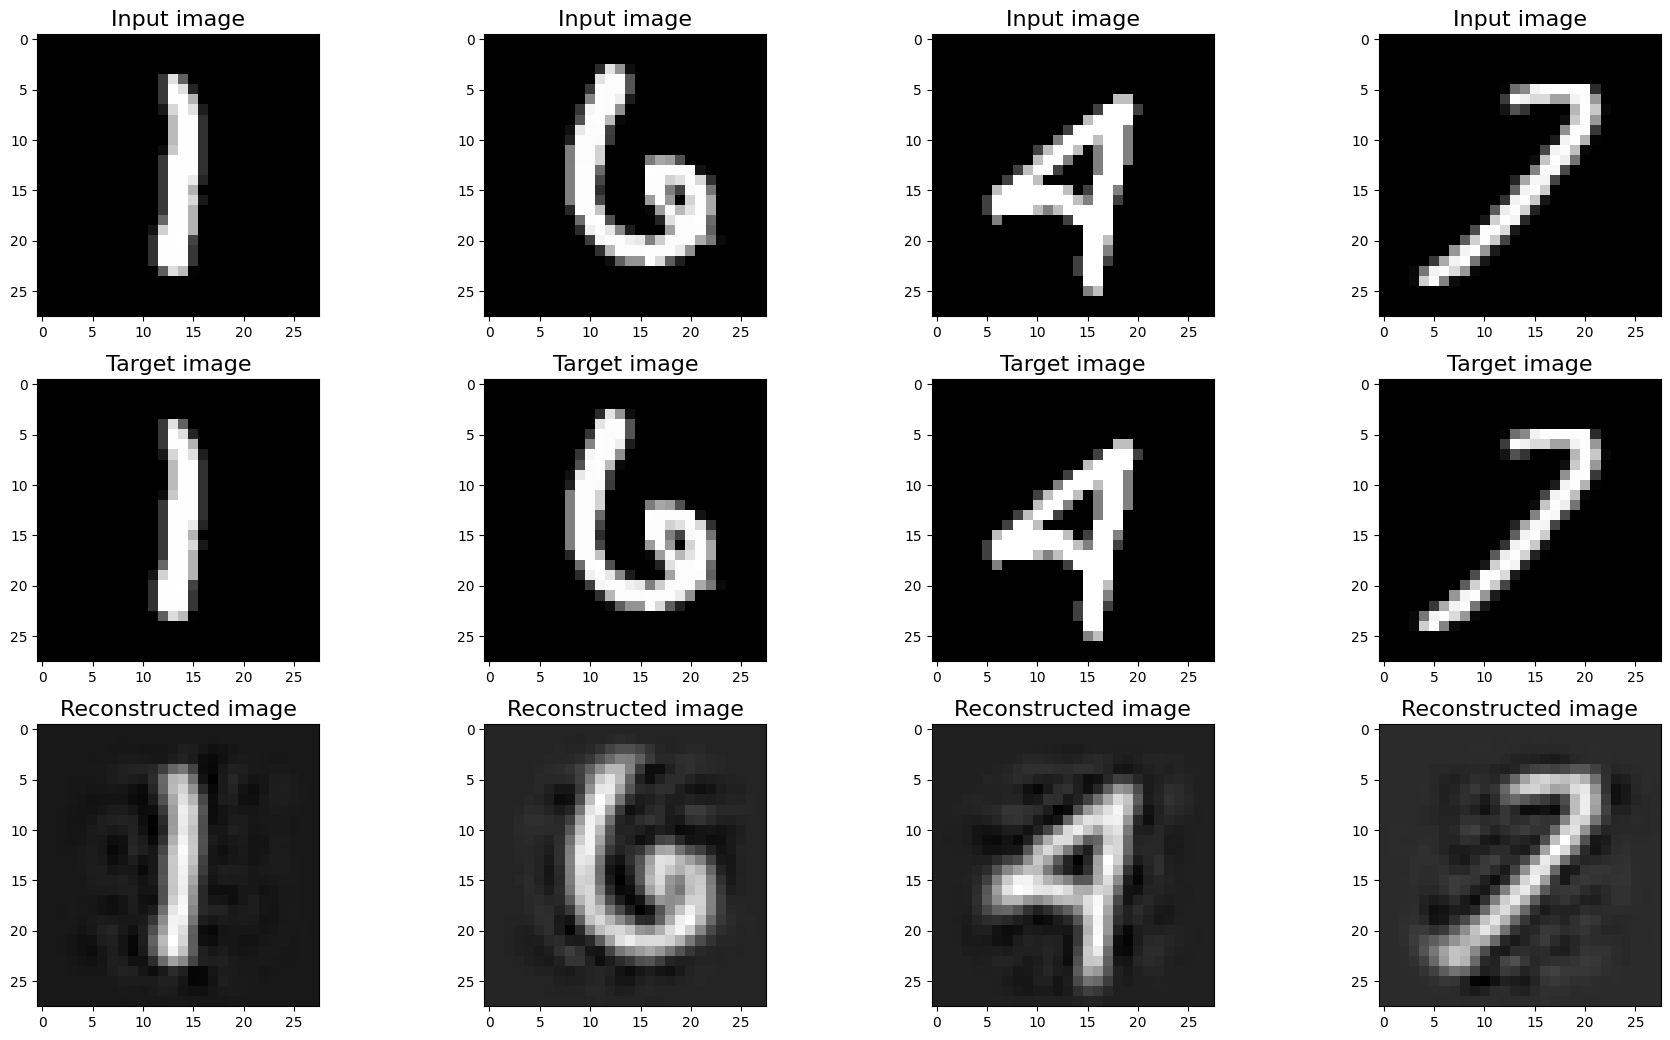

In [13]:
class AutoEncoderLinear(nn.Module):
    def __init__(self, hidden_nodes: int):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, hidden_nodes),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_nodes, 28 * 28),
            nn.Unflatten(dim=-1, unflattened_size=(1, 28, 28)),
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)
    
    def forward(self, x):
        return self.decode(self.encode(x))


epochs = 10
model = AutoEncoderLinear(hidden_nodes=80)
print(torchinfo.summary(model, input_size=(128, 1, 28, 28)))
model.to(device)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()
model, loss_train, acc_train = train_model(
    data_loader=data_loader_train,
    model=model,
    epochs=epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    evaluate_accuracy=False,
    save_subfolder="mnist_autoencoder_linear",
    force_train=False,
)
visualize_loss(cost=loss_train, acc=None)

# Testing the model
loss_test, _ = test_model(
    data_loader=data_loader_test,
    model=model,
    criterion=criterion,
    device=device,
    evaluate_accuracy=True,
)
print(f"Cost: {loss_test:.4f}")
visualize_image_regression(
    data_loader=data_loader_test,
    num_images=4,
    model=model,
)

### Convolutional neural networks
We employ a different neural networks architecture, based on the principle of a convolutional neural network (CNN).
CNNs are particularly suited to process images, since they allow to learn spatial patterns from structured data.

In the following model, we design our encoder as cascade of 3 layers, each composed of:
- A spatial convolution with a kernel of size $(3, 3)$ (using `nn.Conv2d`)
- An activator function (with `nn.ReLU`)
- A max pooling operation, which selects the maximum pixel within a $(2, 2)$ window (with `nn.MaxPool2d`)

For the decoding operation we perform the same operation in reverse, yet:
- We substitute the max pooling with an interpolation nearest neighbor (with `nn.UpsamplingNearest2d`)
- We also employ a sigmoid function to clip the output in the `[0, 1]` range

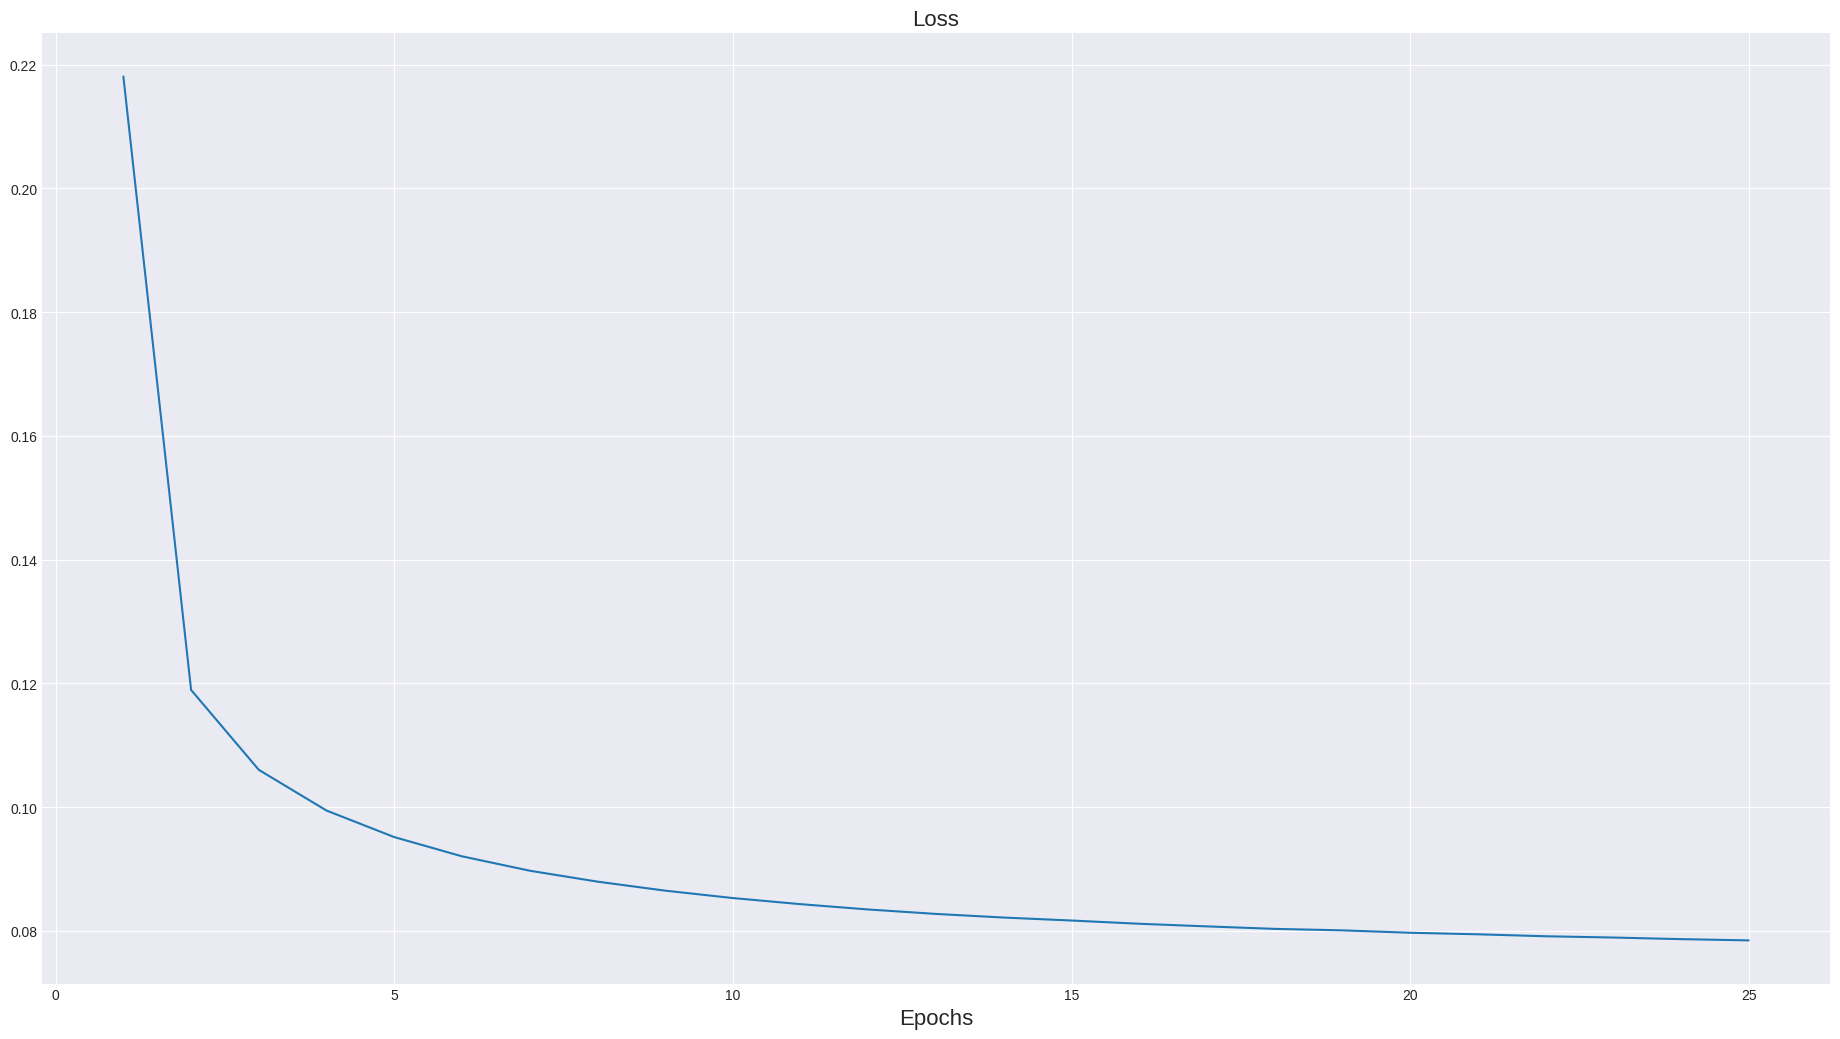

Cost: 0.0776


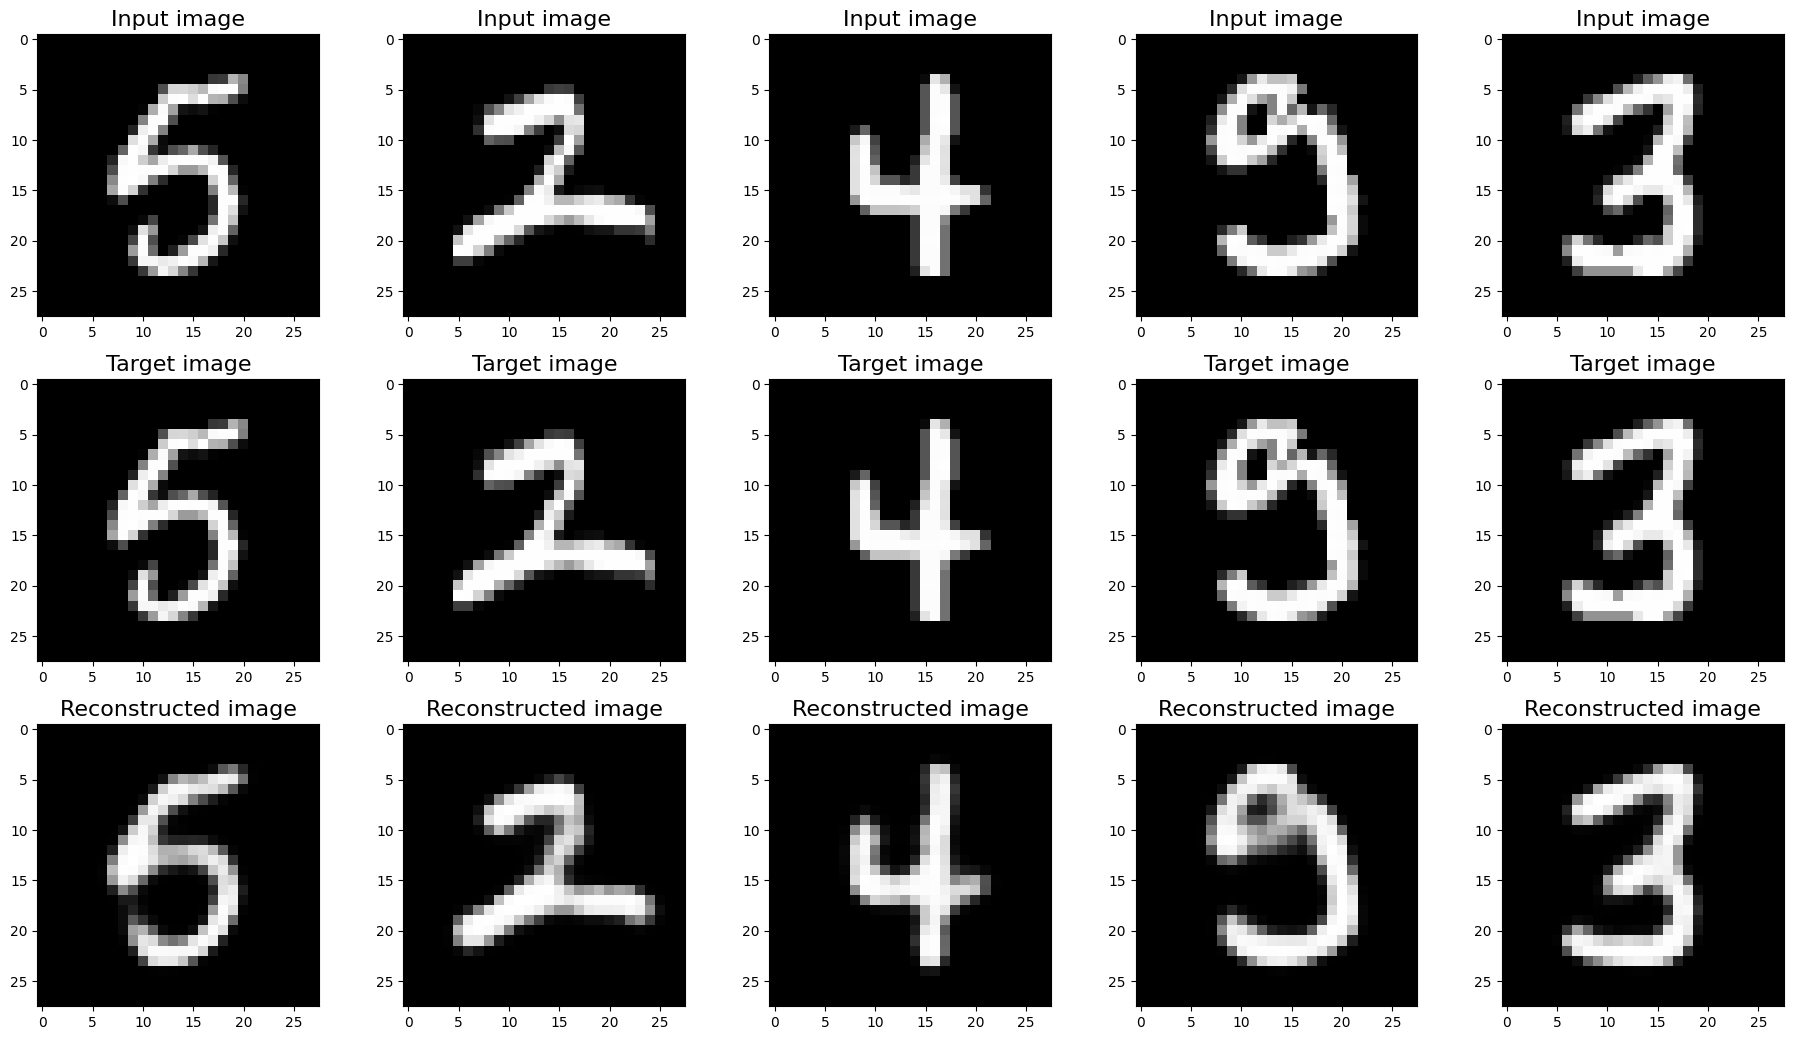

In [15]:
class AutoEncoderConvolutional(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder_1 = nn.Sequential(
            nn.ZeroPad2d(2),
            nn.Conv2d(1, 8, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.encoder_2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.encoder_3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.decoder_1 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
        )
        self.decoder_2 = nn.Sequential(
            nn.Conv2d(32, 16, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
        )
        self.decoder_3 = nn.Sequential(
            nn.Conv2d(16, 8, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
        )
        self.decoder_4 = nn.Sequential(
            nn.Conv2d(8, 1, kernel_size=(3, 3), padding="same"),
            nn.Sigmoid(),
            nn.ZeroPad2d(-2),
        )

    def encode(self, x):
        return self.encoder_3(self.encoder_2(self.encoder_1(x)))

    def decode(self, x):
        return self.decoder_4(self.decoder_3(self.decoder_2(self.decoder_1(x))))

    def forward(self, x):
        return self.decode(self.encode(x))

# Training the model
epochs = 25
learning_rate = 0.001
model = AutoEncoderConvolutional().to(device)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
model, loss_train, acc_train = train_model(
    data_loader=data_loader_train,
    model=model,
    epochs=epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    evaluate_accuracy=False,
    save_subfolder="mnist_autoencoder_convolutional",
    force_train=False,
)
visualize_loss(cost=loss_train, acc=None)

# Testing the model
loss_test, _ = test_model(
    data_loader=data_loader_test,
    model=model,
    criterion=criterion,
    device=device,
    evaluate_accuracy=False,
)
print(f"Cost: {loss_test:.4f}")
visualize_image_regression(
    data_loader=data_loader_test,
    num_images=5,
    model=model,
)

### _Laboratory Activity_
**Exercise:**
- Select a single raw image from the testing dataset (which was defined before as `dataset_test`) and, with the model that was trained above (without re-training), visualize all the features that are encoded at the low-level and on the high-level.
- For the low-level features, visualize the components encoded by a single layer
- For the high-level features, visualize the components encoded by the whole encoder
- _Hints_:
    - Considering how we defined our module (if `image` is the raw image input), if we ignore the downsampling:
        - `model.encoder_1[1](model.encoder_1[0](image))` returns the low-level components;
        - `model.encoder_3[0](model.encoder_2(model.encoder_1(image)))` returns the high-level components.
    - You can convert a 3D image tensor `a` to `numpy` using `a.detach().cpu().numpy().transpose((1, 2, 0))`

**Questions:**
- What is the information that is embedded by features in the low-level and high-level features?
- What do they in particular show in the case of the MNIST dataset?

In [ ]:
# To do

### _Answers_:
[To do]

## Denoising
- In the example below, we use an autoencoder for denoising. 
- The approach is the same as the one described before, however the training pairs are a noisy image and the original one.
- In the following two cells:
  - We define a dataloader for noisy versions of the MNIST dataset (whose standard deviation is defined by `noise_std`)
  - We visualize some samples from the batch of the dataloader
  - We setup a convolutional neural network for the autoencoder
  - We train and test the model

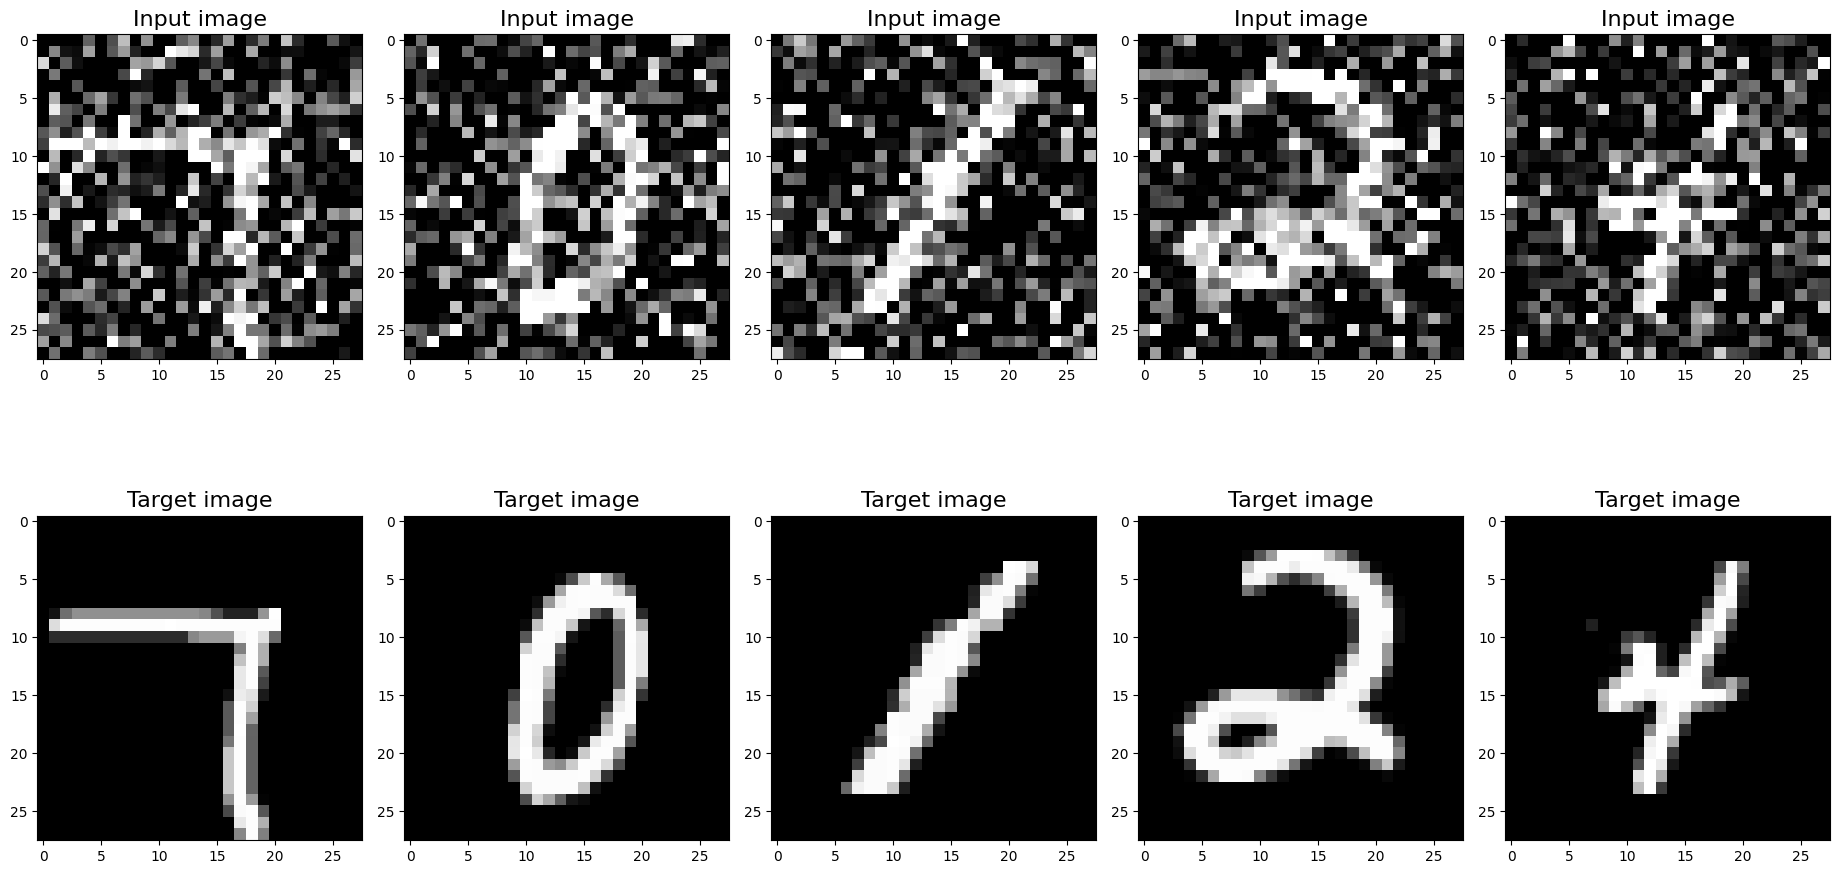

In [17]:
class MnistNoisyDataset(Dataset):
    def __init__(
        self, 
        root: str,
        noise_std: float,
        device: str | torch.device,
        train: bool = True,
        transform = None,
        target_transform = None,
    ):
        dataset = torchvision.datasets.MNIST(root=root, train=train, download=True)
        self.targets = torch.zeros((len(dataset), 1, 28, 28), device=device, dtype=torch.float32)
        self.noisy = torch.zeros((len(dataset), 1, 28, 28), device=device, dtype=torch.float32)

        for ii, data in enumerate(dataset):
            image_pil, _ = data
            self.targets[ii, :, :, :] = transforms.ToTensor()(image_pil)
            self.noisy[ii, :, :, :] = self.targets[ii, :, :, :] + noise_std * torch.randn((1, 28, 28), device=device)
        self.noisy = torch.clip(self.noisy, 0, 1)

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.targets.shape[0]

    def __getitem__(self, idx):
        image = self.noisy[idx, :, :, :]
        target = self.targets[idx, :, :, :]
        if self.transform is not None:
            image = self.transform(image)
        if self.target_transform is not None:
            target = self.target_transform(target)
        return image, target

batch_size = 128
noise_std = 0.5

dataset_train = MnistNoisyDataset(root=data_folder, train=True, device=device, noise_std=noise_std)
dataset_test = MnistNoisyDataset(root=data_folder, train=False, device=device, noise_std=noise_std)

data_loader_train = DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
data_loader_test = DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=True)
visualize_image_regression(
    data_loader=data_loader_test,
    model=None,
)

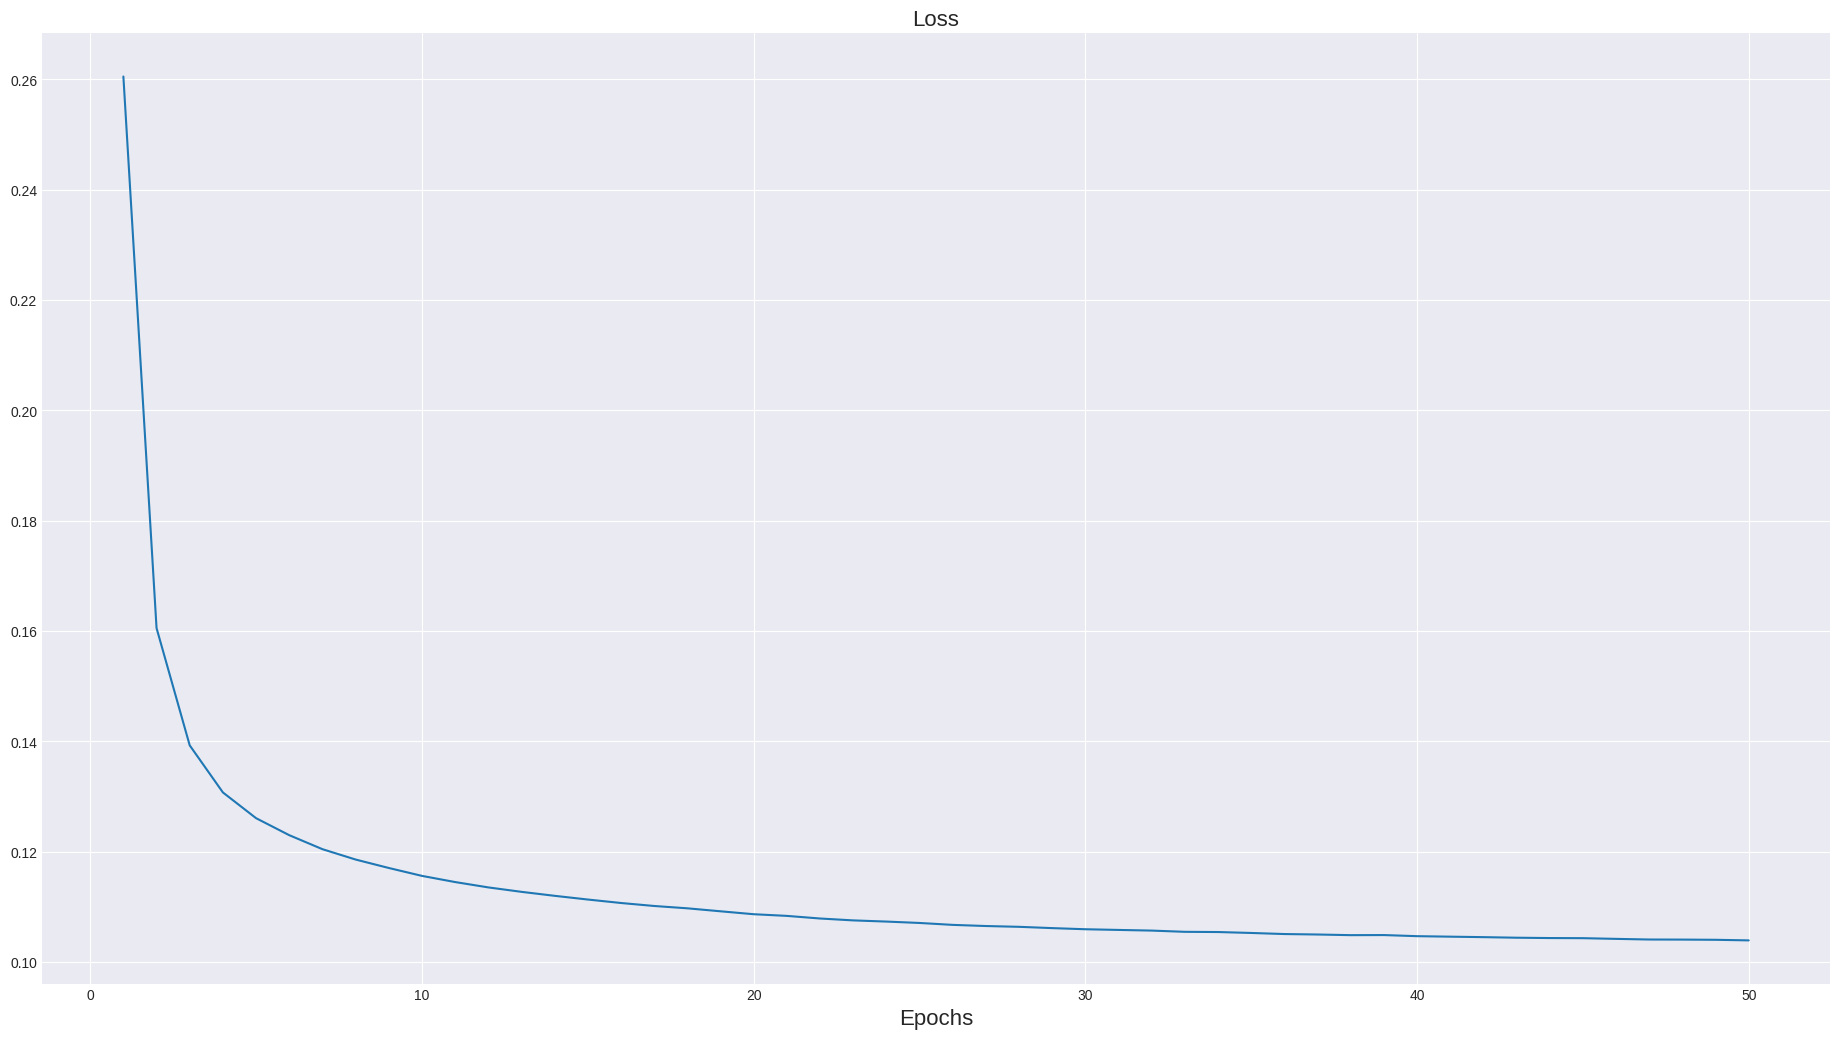

Cost: 0.1034


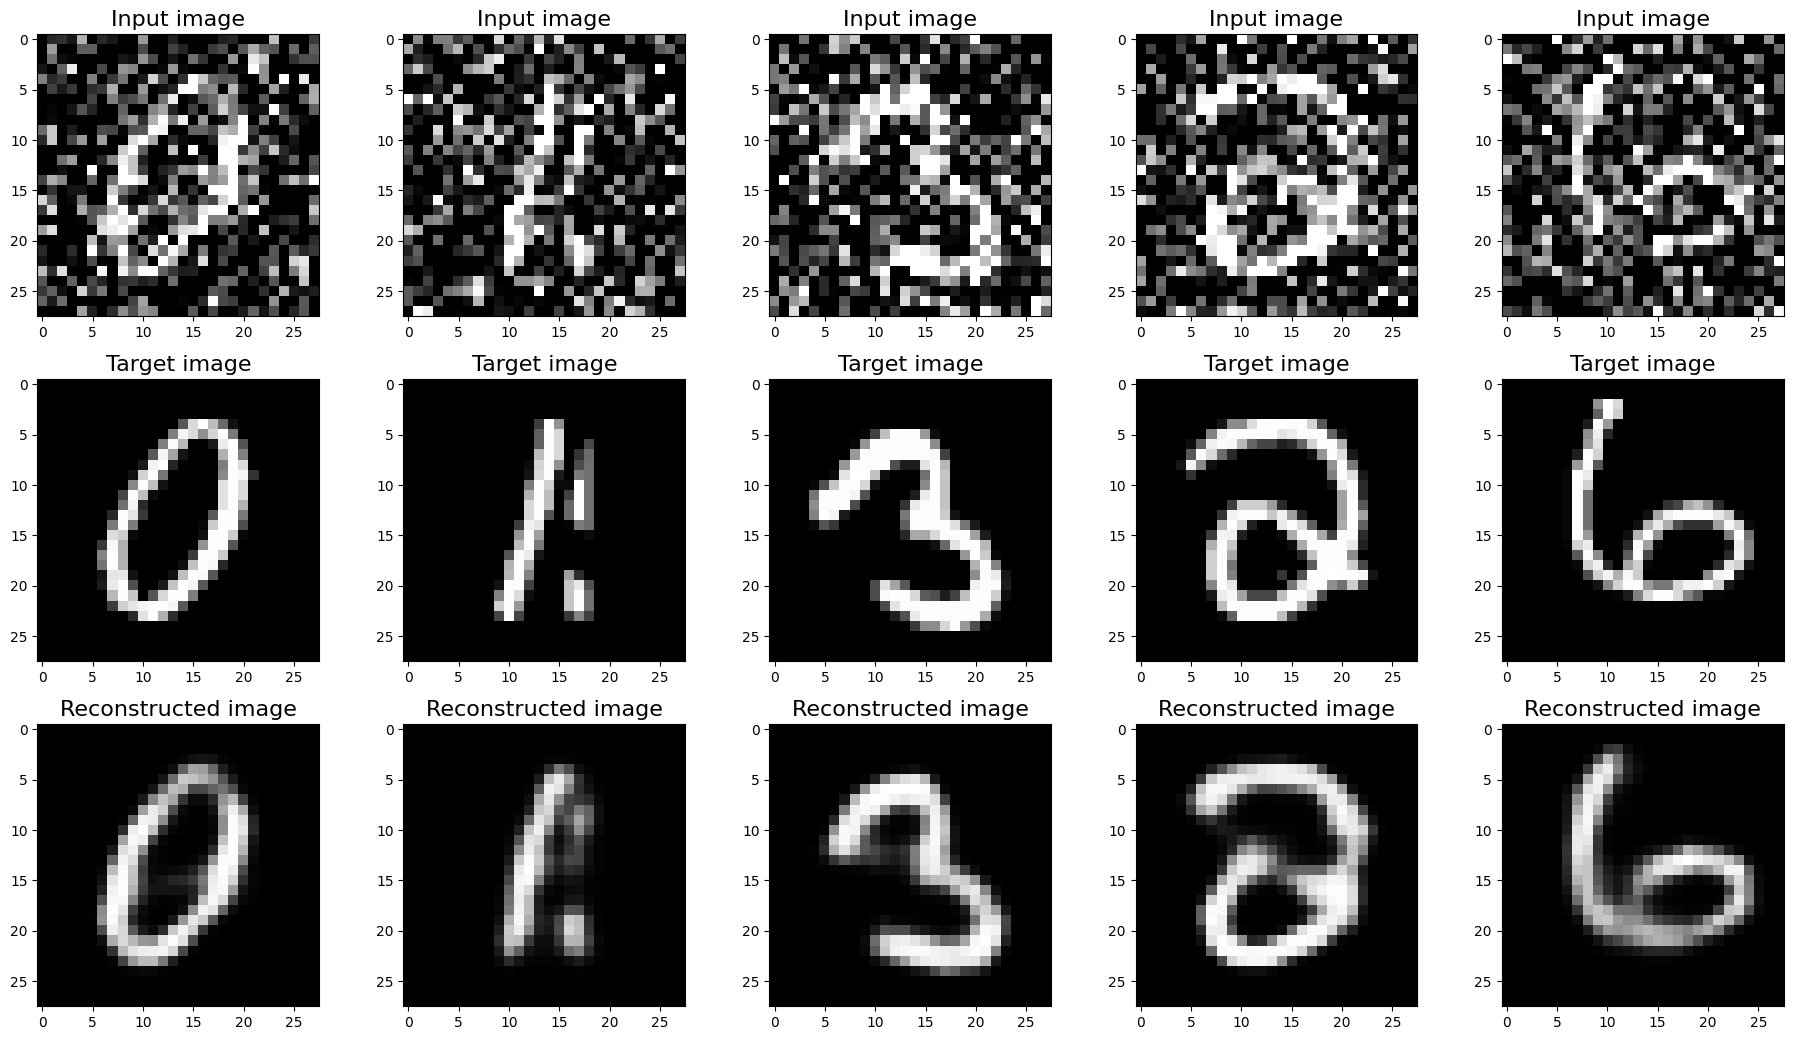

In [18]:
class AutoEncoderConvolutional(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.ZeroPad2d(2),
            nn.Conv2d(1, 8, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(8, 16, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
            nn.Conv2d(16, 32, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2)),
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(32, 16, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(16, 8, kernel_size=(3, 3), padding="same"),
            nn.ReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.Conv2d(8, 1, kernel_size=(3, 3), padding="same"),
            nn.Sigmoid(),
            nn.ZeroPad2d(-2),
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        return self.decode(self.encode(x))
    

epochs = 50
learning_rate = 0.001
model = AutoEncoderConvolutional()
model.to(device)
optimizer = optim.Adam(params=model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()
model, loss_train, acc_train = train_model(
    data_loader=data_loader_train,
    model=model,
    epochs=epochs,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    evaluate_accuracy=False,
    save_subfolder="mnist_denoiser",
    force_train=False,
)

visualize_loss(cost=loss_train, acc=None)
# Testing the model
loss_test, _ = test_model(
    data_loader=data_loader_test,
    model=model,
    criterion=criterion,
    device=device,
    evaluate_accuracy=False,
)
print(f"Cost: {loss_test:.4f}")
visualize_image_regression(
    data_loader=data_loader_test,
    num_images=5,
    model=model,
)

### _Laboratory Activity_
**Exercise**:
- Visualize the performances of the system (without re-traning) with noise standard deviation (`noise_std`) equal to 0.3 and equal to 0.8
- __Optional__: Give an estimate of the noise standard deviation for which the MSE is below 0.025
- __Optional__: For the noise level `noise_std=0.5`, compare the performances with a classic median denoiser with a (3, 3) size kernel

**Question**:
- The performances of the denoised based on the autoencoder are much better than classic techniques such as median filtering. Why isn't the denoiser we just trained used for every denoising problem?

In [ ]:
# To do

### _Answers_:
[To do]